# **Neural Networks Project**

## Imports

In [5]:
# Importing libraries.
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, ResNet50V2, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend
print("Libraries imported.")

# Setting seeds to guarantee the repeatability of the experiments.
seed = 1792507 # my matricula number
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
print("Seeds set.")

Libraries imported.
Seeds set.


## Load .npy files

In [2]:
# Train data
xtrain_128 = np.load('data/x_train_128.npy')
xtrain_224 = np.load('data/x_train_224.npy')
xtrain_229 = np.load('data/x_train_229.npy')
ytrain = np.load('data/y_train.npy')
# Test data
xtest_128 = np.load('data/x_test_128.npy')
xtest_224 = np.load('data/x_test_224.npy')
xtest_229 = np.load('data/x_test_229.npy')
ytest = np.load('data/y_test.npy')
print("Data loaded.")

Data loaded.


## Main functions' definition

In [3]:
# Model function: stage -> model. 
# If stage > 1, load last trained model's weights for transfer learning.
def create_model(stage):
    model = Sequential()
    # Network's body: ResNet50 without head, pre-trained with imagenet weights.
    # Also tried 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5' weights: same result => they are a valid alternative if needed.
    if(stage == 1):
        in_shape = (128, 128, 3)
    elif(stage == 2):
        in_shape = (224, 224, 3)
    elif(stage == 3):
        in_shape = (229, 229, 3)
    resnet = ResNet50V2(include_top = False, input_shape = in_shape, pooling = 'avg', weights="imagenet")
    model.add(resnet)
    #resnet.load_weights('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name = True)
    
    # Network's head: sequence of drop out, batch normalization and linear layers.
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu')) 
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(3, activation = 'softmax'))
    
    if(stage == 2):
        model.load_weights("Models/model1.h5")
    elif(stage == 3):
        model.load_weights("Models/model2.h5")
    return model

# Plot function: training history -> accuracy and loss plots.
def plot_history(history, title='plot'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training accuracy')
    plt.plot(val_acc, label='Validation accuracy')
    plt.legend(loc='upper right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()), 1.0])
    plt.title('Training and Validation accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training loss')
    plt.plot(val_loss, label='Validation loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.ylim([0,1.0])
    plt.title('Training and Validation loss')
    plt.xlabel('epoch')
    plt.savefig('Pictures/'+title+'.jpg')
    plt.show()

# Test function: x, y, model -> confusion matrix and metrics evaluation.
def test(xt, y_true, mod, title='confusion matrix'):
    model = tf.keras.models.load_model(mod)
    y_pred = np.argmax(model.predict(xt), axis=1)
    labels=['normal', 'pneumonia', 'COVID-19']
    
    # Generate confusion matrix.
    C2 = confusion_matrix(y_true, y_pred)
    C = pd.DataFrame(C2, columns=labels, index=labels)
    dim, _ = C2.shape
    f, ax = plt.subplots()
    sns.heatmap(C, annot=True, ax=ax, cmap=plt.cm.binary)
    ax.set_title(title)
    ax.set_xlabel('predict')
    ax.set_ylabel('true')
    plt.savefig('Pictures/'+title+'.jpg')
    plt.show()
    
    # Compute and print metrics.
    for i in range(dim):
        precision = C2[i, i] / sum(C2[:, i])
        recall = C2[i, i] / sum(C2[i, :])
        f1 = 2 * precision * recall / (precision + recall)
        print('In class: {}\tTotal samples: {}\tTrue predict samples: {}\nprecision = {:.4f},\trecall = {:.4f},\tf1-score = {:.4f}\n'.format(labels[i], sum(C2[i, :]), C2[i, i], precision, recall, f1))
    print('AVERAGE F1-SCORE = {:.4f}'.format(f1_score(y_true, y_pred, average='micro')), '\n', '-' * 90)


In [4]:
# Train function: data -> trained models
# Training in 3 stages using progressive resizing and fine-tuning as in the paper.
def train(xtrain128, xtrain224, xtrain229):
    y = tf.keras.utils.to_categorical(ytrain, 3)
    yv = tf.keras.utils.to_categorical(ytest, 3)
    model_checkpoint_callback1 = ModelCheckpoint(filepath='Models/model1.h5', monitor='val_accuracy',
                                                mode='max', save_best_only=True)
    model_checkpoint_callback2 = ModelCheckpoint(filepath='Models/model2.h5', monitor='val_accuracy',
                                                mode='max', save_best_only=True)
    model_checkpoint_callback3 = ModelCheckpoint(filepath='Models/model3.h5', monitor='val_accuracy',
                                                mode='max', save_best_only=True)
    
    # STAGE 1
    print('STAGE 1')
    # Training on 128*128 data with freezed ResNet50 layers.
    model1 = create_model(1)
    model1.layers[0].trainable = False
    print(model1.summary())
    opt = tf.keras.optimizers.Adam(lr=0.001)
    model1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    hist = model1.fit(xtrain128, y, batch_size=32,  epochs=3, verbose=1, validation_data=(xtest_128, yv), callbacks=[model_checkpoint_callback1])
    plot_history(hist, '128_1')
    # Fine-tuning: training on 128*128 data with unfreezed ResNet50 layers.
    model1.layers[0].trainable = True
    print(model1.summary())
    opt = tf.keras.optimizers.Adam(lr=0.001)
    model1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    hist = model1.fit(xtrain128, y, batch_size=32, epochs=5, verbose=1, validation_data=(xtest_128, yv), callbacks=[model_checkpoint_callback1])
    plot_history(hist, '128_2')
    # Stage 1 validation.
    print('\n', '-'*90, '\n')
    print('STAGE 1 VALIDATION')
    test(xtrain128, ytrain, 'Models/model1.h5', 'confusion_matrix_train1')
    test(xtest_128, ytest, 'Models/model1.h5', 'confusion_matrix_test1')
    print('\n', '-'*90, '\n')
    
    # STAGE 2
    print('STAGE 2')
    # Training on 224*224 data with freezed ResNet50 layers.
    model2 = create_model(2)
    model2.layers[0].trainable = False
    print(model2.summary())
    opt = tf.keras.optimizers.Adam(lr=0.0001)
    model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    hist = model2.fit(xtrain224, y, batch_size=32,  epochs=3, verbose=1, validation_data=(xtest_224, yv), callbacks=[model_checkpoint_callback2])
    plot_history(hist, '224_1')
    # Fine-tuning: training on 224*224 data with unfreezed ResNet50 layers.
    model2.layers[0].trainable = True
    print(model2.summary())
    opt = tf.keras.optimizers.Adam(lr=0.0001)
    model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    hist = model2.fit(xtrain224, y, batch_size=32, epochs=5, verbose=1, validation_data=(xtest_224, yv), callbacks=[model_checkpoint_callback2])
    plot_history(hist, '224_2')
    # Stage 2 validation.
    print('\n', '-'*90, '\n')
    print('STAGE 2 VALIDATION')
    test(xtrain224, ytrain, 'Models/model2.h5', 'confusion_matrix_train2')
    test(xtest_224, ytest, 'Models/model2.h5', 'confusion_matrix_test2')
    print('\n', '-'*90, '\n')
    
    #STAGE 3
    print('STAGE 3')
    # Fine-tuning: training on 229*229 data with unfreezed ResNet50 layers.
    model3 = create_model(3)
    print(model3.summary())
    opt = tf.keras.optimizers.Adam(lr=0.00001)
    model3.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    hist = model3.fit(xtrain229, y, batch_size=32, epochs=5, verbose=1, validation_data=(xtest_229, yv), callbacks=[model_checkpoint_callback3])
    plot_history(hist, '229_1')
    # Stage 3 validation.
    print('\n', '-'*90, '\n')
    print('STAGE 3 VALIDATION')
    test(xtrain229, ytrain, 'Models/model3.h5', 'confusion_matrix_train3')
    test(xtest_229, ytest, 'Models/model3.h5', 'confusion_matrix_test3')

## Training and Evaluation

STAGE 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)        

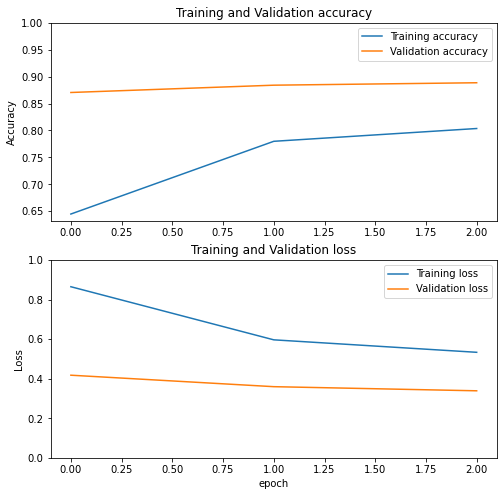

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3

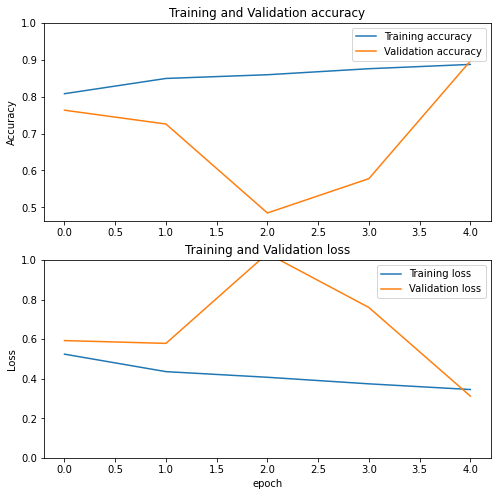


 ------------------------------------------------------------------------------------------ 

STAGE 1 VALIDATION


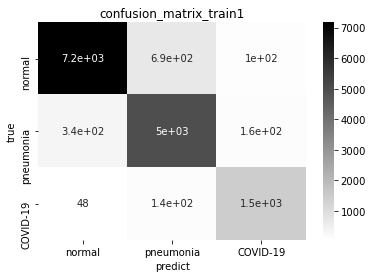

In class: normal	Total samples: 7966	True predict samples: 7173
precision = 0.9489,	recall = 0.9005,	f1-score = 0.9241

In class: pneumonia	Total samples: 5475	True predict samples: 4979
precision = 0.8565,	recall = 0.9094,	f1-score = 0.8822

In class: COVID-19	Total samples: 1645	True predict samples: 1452
precision = 0.8471,	recall = 0.8827,	f1-score = 0.8645

AVERAGE F1-SCORE = 0.9018 
 ------------------------------------------------------------------------------------------


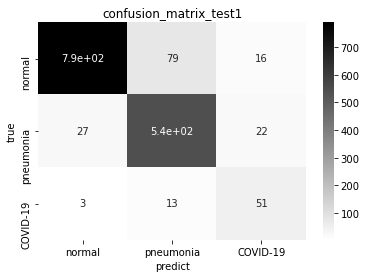

In class: normal	Total samples: 885	True predict samples: 790
precision = 0.9634,	recall = 0.8927,	f1-score = 0.9267

In class: pneumonia	Total samples: 594	True predict samples: 545
precision = 0.8556,	recall = 0.9175,	f1-score = 0.8855

In class: COVID-19	Total samples: 67	True predict samples: 51
precision = 0.5730,	recall = 0.7612,	f1-score = 0.6538

AVERAGE F1-SCORE = 0.8965 
 ------------------------------------------------------------------------------------------

 ------------------------------------------------------------------------------------------ 

STAGE 2
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
bat

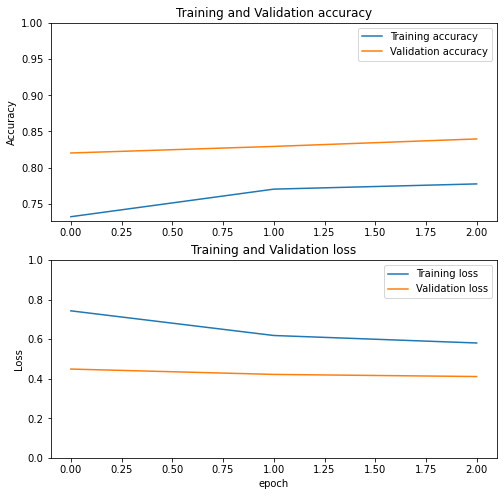

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_5 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)               1024      
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

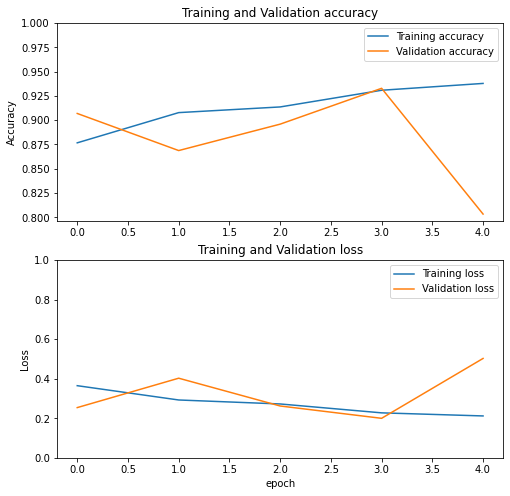


 ------------------------------------------------------------------------------------------ 

STAGE 2 VALIDATION


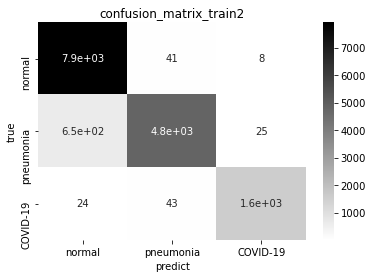

In class: normal	Total samples: 7966	True predict samples: 7917
precision = 0.9214,	recall = 0.9938,	f1-score = 0.9563

In class: pneumonia	Total samples: 5475	True predict samples: 4799
precision = 0.9828,	recall = 0.8765,	f1-score = 0.9266

In class: COVID-19	Total samples: 1645	True predict samples: 1578
precision = 0.9795,	recall = 0.9593,	f1-score = 0.9693

AVERAGE F1-SCORE = 0.9475 
 ------------------------------------------------------------------------------------------


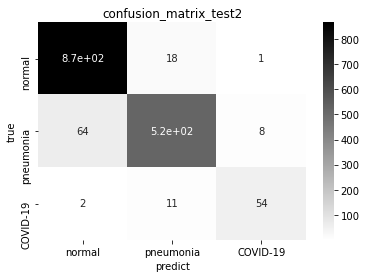

In class: normal	Total samples: 885	True predict samples: 866
precision = 0.9292,	recall = 0.9785,	f1-score = 0.9532

In class: pneumonia	Total samples: 594	True predict samples: 522
precision = 0.9474,	recall = 0.8788,	f1-score = 0.9118

In class: COVID-19	Total samples: 67	True predict samples: 54
precision = 0.8571,	recall = 0.8060,	f1-score = 0.8308

AVERAGE F1-SCORE = 0.9327 
 ------------------------------------------------------------------------------------------

 ------------------------------------------------------------------------------------------ 

STAGE 3
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
bat

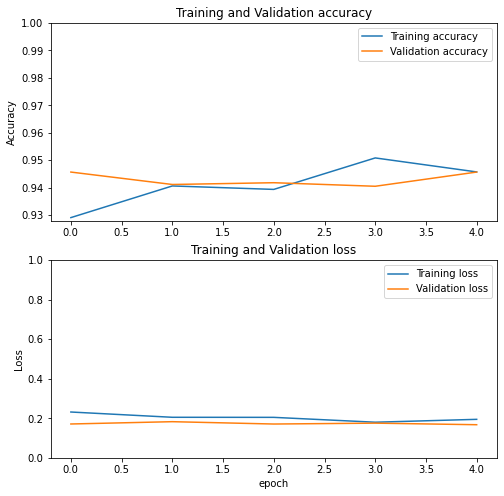


 ------------------------------------------------------------------------------------------ 

STAGE 3 VALIDATION


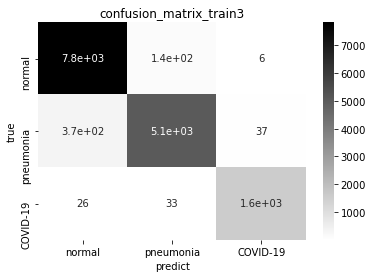

In class: normal	Total samples: 7966	True predict samples: 7821
precision = 0.9520,	recall = 0.9818,	f1-score = 0.9667

In class: pneumonia	Total samples: 5475	True predict samples: 5070
precision = 0.9672,	recall = 0.9260,	f1-score = 0.9462

In class: COVID-19	Total samples: 1645	True predict samples: 1586
precision = 0.9736,	recall = 0.9641,	f1-score = 0.9688

AVERAGE F1-SCORE = 0.9596 
 ------------------------------------------------------------------------------------------


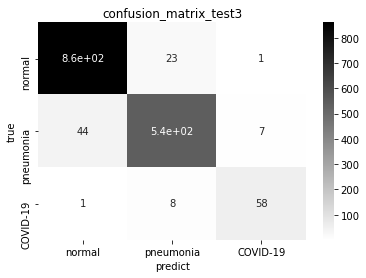

In class: normal	Total samples: 885	True predict samples: 861
precision = 0.9503,	recall = 0.9729,	f1-score = 0.9615

In class: pneumonia	Total samples: 594	True predict samples: 543
precision = 0.9460,	recall = 0.9141,	f1-score = 0.9298

In class: COVID-19	Total samples: 67	True predict samples: 58
precision = 0.8788,	recall = 0.8657,	f1-score = 0.8722

AVERAGE F1-SCORE = 0.9457 
 ------------------------------------------------------------------------------------------


In [5]:
# Main training process execution.
train(xtrain_128, xtrain_224, xtrain_229)

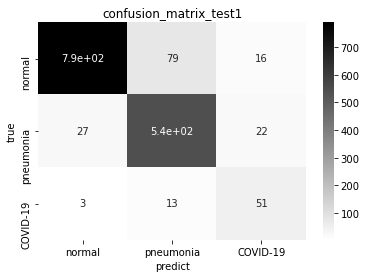

In class: normal	Total samples: 885	True predict samples: 790
precision = 0.9634,	recall = 0.8927,	f1-score = 0.9267

In class: pneumonia	Total samples: 594	True predict samples: 545
precision = 0.8556,	recall = 0.9175,	f1-score = 0.8855

In class: COVID-19	Total samples: 67	True predict samples: 51
precision = 0.5730,	recall = 0.7612,	f1-score = 0.6538

AVERAGE F1-SCORE = 0.8965 
 ------------------------------------------------------------------------------------------


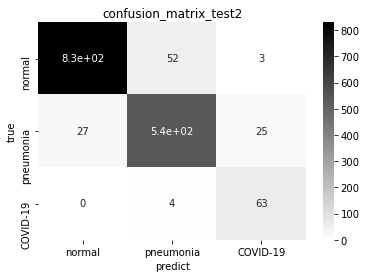

In class: normal	Total samples: 885	True predict samples: 830
precision = 0.9685,	recall = 0.9379,	f1-score = 0.9529

In class: pneumonia	Total samples: 594	True predict samples: 542
precision = 0.9064,	recall = 0.9125,	f1-score = 0.9094

In class: COVID-19	Total samples: 67	True predict samples: 63
precision = 0.6923,	recall = 0.9403,	f1-score = 0.7975

AVERAGE F1-SCORE = 0.9282 
 ------------------------------------------------------------------------------------------


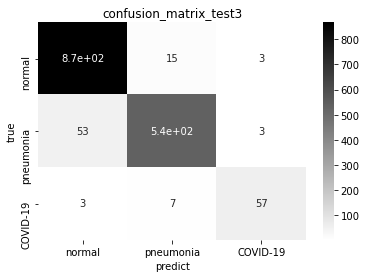

In class: normal	Total samples: 885	True predict samples: 867
precision = 0.9393,	recall = 0.9797,	f1-score = 0.9591

In class: pneumonia	Total samples: 594	True predict samples: 538
precision = 0.9607,	recall = 0.9057,	f1-score = 0.9324

In class: COVID-19	Total samples: 67	True predict samples: 57
precision = 0.9048,	recall = 0.8507,	f1-score = 0.8769

AVERAGE F1-SCORE = 0.9457 
 ------------------------------------------------------------------------------------------


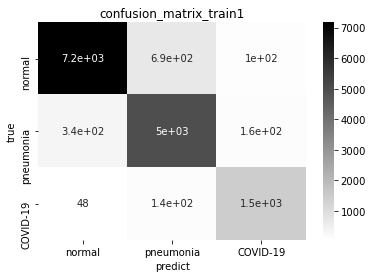

In class: normal	Total samples: 7966	True predict samples: 7173
precision = 0.9489,	recall = 0.9005,	f1-score = 0.9241

In class: pneumonia	Total samples: 5475	True predict samples: 4979
precision = 0.8565,	recall = 0.9094,	f1-score = 0.8822

In class: COVID-19	Total samples: 1645	True predict samples: 1452
precision = 0.8471,	recall = 0.8827,	f1-score = 0.8645

AVERAGE F1-SCORE = 0.9018 
 ------------------------------------------------------------------------------------------


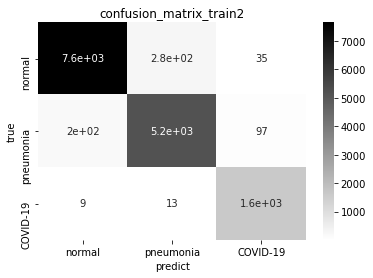

In class: normal	Total samples: 7966	True predict samples: 7649
precision = 0.9738,	recall = 0.9602,	f1-score = 0.9669

In class: pneumonia	Total samples: 5475	True predict samples: 5181
precision = 0.9461,	recall = 0.9463,	f1-score = 0.9462

In class: COVID-19	Total samples: 1645	True predict samples: 1623
precision = 0.9248,	recall = 0.9866,	f1-score = 0.9547

AVERAGE F1-SCORE = 0.9580 
 ------------------------------------------------------------------------------------------


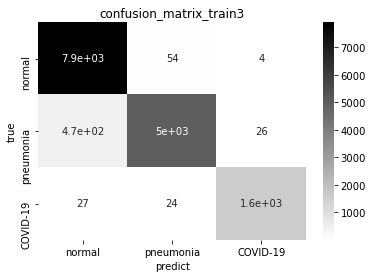

In class: normal	Total samples: 7966	True predict samples: 7908
precision = 0.9409,	recall = 0.9927,	f1-score = 0.9661

In class: pneumonia	Total samples: 5475	True predict samples: 4979
precision = 0.9846,	recall = 0.9094,	f1-score = 0.9455

In class: COVID-19	Total samples: 1645	True predict samples: 1594
precision = 0.9815,	recall = 0.9690,	f1-score = 0.9752

AVERAGE F1-SCORE = 0.9599 
 ------------------------------------------------------------------------------------------


In [6]:
# Best evaluation metrics found. (just to have them all in one place)

test(xtest_128, ytest, 'Models_best/model1.h5', 'confusion_matrix_test1')
test(xtest_224, ytest, 'Models_best/model2.h5', 'confusion_matrix_test2')
test(xtest_229, ytest, 'Models_best/model3.h5', 'confusion_matrix_test3')

test(xtrain_128, ytrain, 'Models_best/model1.h5', 'confusion_matrix_train1')
test(xtrain_224, ytrain, 'Models_best/model2.h5', 'confusion_matrix_train2')
test(xtrain_229, ytrain, 'Models_best/model3.h5', 'confusion_matrix_train3')

## Comparison with other models

### Simple CNN

Epoch 1/21
472/472 [==============================] - 16s 32ms/step - loss: 0.7329 - accuracy: 0.6864 - val_loss: 0.5544 - val_accuracy: 0.7775
Epoch 2/21
472/472 [==============================] - 15s 31ms/step - loss: 0.5101 - accuracy: 0.7981 - val_loss: 0.4101 - val_accuracy: 0.8590
Epoch 3/21
472/472 [==============================] - 15s 32ms/step - loss: 0.4393 - accuracy: 0.8349 - val_loss: 0.4057 - val_accuracy: 0.8499
Epoch 4/21
472/472 [==============================] - 15s 31ms/step - loss: 0.4003 - accuracy: 0.8484 - val_loss: 0.3917 - val_accuracy: 0.8519
Epoch 5/21
472/472 [==============================] - 15s 31ms/step - loss: 0.3720 - accuracy: 0.8609 - val_loss: 0.3822 - val_accuracy: 0.8519
Epoch 6/21
472/472 [==============================] - 15s 31ms/step - loss: 0.3498 - accuracy: 0.8643 - val_loss: 0.3883 - val_accuracy: 0.8454
Epoch 7/21
472/472 [==============================] - 15s 31ms/step - loss: 0.3170 - accuracy: 0.8821 - val_loss: 0.3548 - val_accuracy:

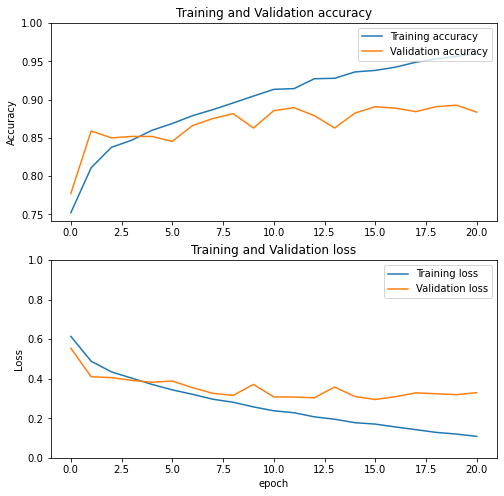


 ------------------------------------------------------------------------------------------ 

HANDMADE VALIDATION


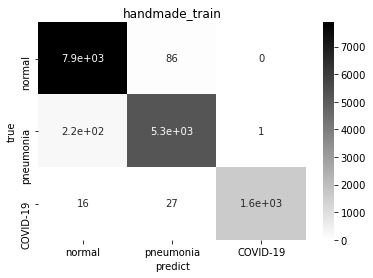

In class: normal	Total samples: 7966	True predict samples: 7880
precision = 0.9707,	recall = 0.9892,	f1-score = 0.9799

In class: pneumonia	Total samples: 5475	True predict samples: 5252
precision = 0.9789,	recall = 0.9593,	f1-score = 0.9690

In class: COVID-19	Total samples: 1645	True predict samples: 1602
precision = 0.9994,	recall = 0.9739,	f1-score = 0.9865

AVERAGE F1-SCORE = 0.9767 
 ------------------------------------------------------------------------------------------


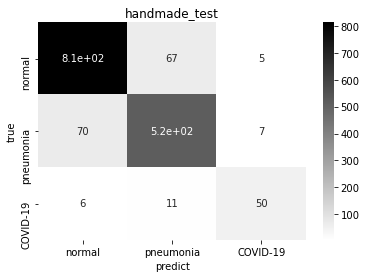

In class: normal	Total samples: 885	True predict samples: 813
precision = 0.9145,	recall = 0.9186,	f1-score = 0.9166

In class: pneumonia	Total samples: 594	True predict samples: 517
precision = 0.8689,	recall = 0.8704,	f1-score = 0.8696

In class: COVID-19	Total samples: 67	True predict samples: 50
precision = 0.8065,	recall = 0.7463,	f1-score = 0.7752

AVERAGE F1-SCORE = 0.8926 
 ------------------------------------------------------------------------------------------


In [11]:
y = tf.keras.utils.to_categorical(ytrain, 3)
yv = tf.keras.utils.to_categorical(ytest, 3)
model_checkpoint_callback = ModelCheckpoint(filepath='Models/handmade.h5', monitor='val_accuracy',
                                            mode='max', save_best_only=True)
model = Sequential()
model.add(Conv2D(32, 3, padding="same", activation="relu", input_shape=(229,229,3)))
model.add(MaxPool2D())
model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(3, activation="softmax"))

opt = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
hist = model.fit(xtrain_229, y, batch_size=32,  epochs=21, verbose=1, validation_data=(xtest_229, yv), callbacks=[model_checkpoint_callback])
plot_history(hist, 'handmade')
print('\n', '-'*90, '\n')
print('HANDMADE VALIDATION')
test(xtrain_229, ytrain, 'Models/handmade.h5', 'handmade_train')
test(xtest_229, ytest, 'Models/handmade.h5', 'handmade_test')

### ResNet50 (but without Transfer Learning)

Epoch 1/21
472/472 [==============================] - 111s 223ms/step - loss: 0.8297 - accuracy: 0.6593 - val_loss: 1.3530 - val_accuracy: 0.3771
Epoch 2/21
472/472 [==============================] - 104s 221ms/step - loss: 0.4855 - accuracy: 0.8097 - val_loss: 0.7298 - val_accuracy: 0.7070
Epoch 3/21
472/472 [==============================] - 105s 222ms/step - loss: 0.3902 - accuracy: 0.8507 - val_loss: 0.8159 - val_accuracy: 0.6856
Epoch 4/21
472/472 [==============================] - 104s 221ms/step - loss: 0.3045 - accuracy: 0.8836 - val_loss: 0.5765 - val_accuracy: 0.7671
Epoch 5/21
472/472 [==============================] - 105s 222ms/step - loss: 0.2505 - accuracy: 0.9076 - val_loss: 0.5718 - val_accuracy: 0.7814
Epoch 6/21
472/472 [==============================] - 105s 223ms/step - loss: 0.1995 - accuracy: 0.9272 - val_loss: 0.5687 - val_accuracy: 0.7665
Epoch 7/21
472/472 [==============================] - 105s 222ms/step - loss: 0.1392 - accuracy: 0.9520 - val_loss: 0.9996 -

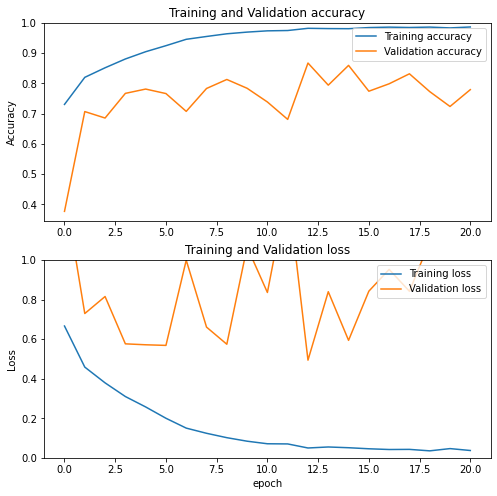


 ------------------------------------------------------------------------------------------ 

RESNET_NO_TRANSFER VALIDATION


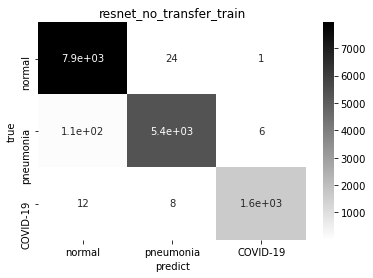

In class: normal	Total samples: 7966	True predict samples: 7941
precision = 0.9850,	recall = 0.9969,	f1-score = 0.9909

In class: pneumonia	Total samples: 5475	True predict samples: 5360
precision = 0.9941,	recall = 0.9790,	f1-score = 0.9865

In class: COVID-19	Total samples: 1645	True predict samples: 1625
precision = 0.9957,	recall = 0.9878,	f1-score = 0.9918

AVERAGE F1-SCORE = 0.9894 
 ------------------------------------------------------------------------------------------


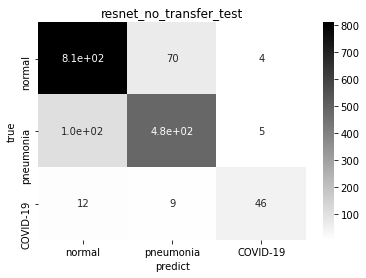

In class: normal	Total samples: 885	True predict samples: 811
precision = 0.8739,	recall = 0.9164,	f1-score = 0.8946

In class: pneumonia	Total samples: 594	True predict samples: 484
precision = 0.8597,	recall = 0.8148,	f1-score = 0.8366

In class: COVID-19	Total samples: 67	True predict samples: 46
precision = 0.8364,	recall = 0.6866,	f1-score = 0.7541

AVERAGE F1-SCORE = 0.8674 
 ------------------------------------------------------------------------------------------


In [7]:
y = tf.keras.utils.to_categorical(ytrain, 3)
yv = tf.keras.utils.to_categorical(ytest, 3)
model_checkpoint_callback = ModelCheckpoint(filepath='Models/resnet_no_transfer.h5', monitor='val_accuracy',
                                            mode='max', save_best_only=True)
model = Sequential()
resnet = ResNet50V2(include_top = False, input_shape = (229, 229, 3), pooling = 'avg', weights= None)
model.add(resnet)
model.add(Flatten())
model.add(Dense(3, activation = 'softmax'))

opt = tf.keras.optimizers.Adam(lr=0.00001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
hist = model.fit(xtrain_229, y, batch_size=32,  epochs=21, verbose=1, validation_data=(xtest_229, yv), callbacks=[model_checkpoint_callback])
plot_history(hist, 'resnet_no_transfer')
print('\n', '-'*90, '\n')
print('RESNET_NO_TRANSFER VALIDATION')
test(xtrain_229, ytrain, 'Models/resnet_no_transfer.h5', 'resnet_no_transfer_train')
test(xtest_229, ytest, 'Models/resnet_no_transfer.h5', 'resnet_no_transfer_test')

### VGG16 (also without Transfer Learning)

Epoch 1/21
472/472 [==============================] - 135s 285ms/step - loss: 0.9618 - accuracy: 0.5312 - val_loss: 0.5912 - val_accuracy: 0.8157
Epoch 2/21
472/472 [==============================] - 134s 284ms/step - loss: 0.6707 - accuracy: 0.7377 - val_loss: 0.4767 - val_accuracy: 0.8260
Epoch 3/21
472/472 [==============================] - 134s 285ms/step - loss: 0.5546 - accuracy: 0.7845 - val_loss: 0.4382 - val_accuracy: 0.8279
Epoch 4/21
472/472 [==============================] - 134s 285ms/step - loss: 0.4932 - accuracy: 0.8149 - val_loss: 0.4242 - val_accuracy: 0.8331
Epoch 5/21
472/472 [==============================] - 135s 286ms/step - loss: 0.4369 - accuracy: 0.8343 - val_loss: 0.3780 - val_accuracy: 0.8635
Epoch 6/21
472/472 [==============================] - 135s 285ms/step - loss: 0.4082 - accuracy: 0.8456 - val_loss: 0.3344 - val_accuracy: 0.8719
Epoch 7/21
472/472 [==============================] - 135s 286ms/step - loss: 0.3376 - accuracy: 0.8725 - val_loss: 0.3258 -

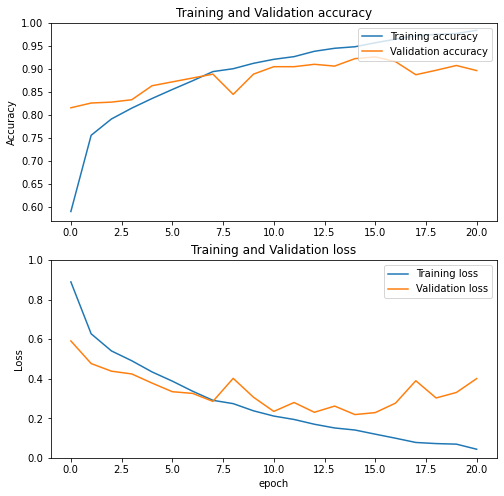


 ------------------------------------------------------------------------------------------ 

VGG16 VALIDATION


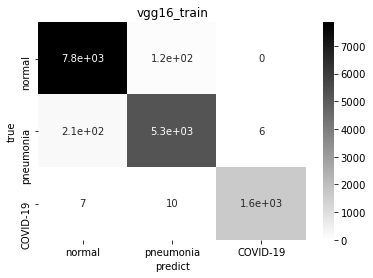

In class: normal	Total samples: 7966	True predict samples: 7850
precision = 0.9736,	recall = 0.9854,	f1-score = 0.9795

In class: pneumonia	Total samples: 5475	True predict samples: 5263
precision = 0.9766,	recall = 0.9613,	f1-score = 0.9689

In class: COVID-19	Total samples: 1645	True predict samples: 1628
precision = 0.9963,	recall = 0.9897,	f1-score = 0.9930

AVERAGE F1-SCORE = 0.9771 
 ------------------------------------------------------------------------------------------


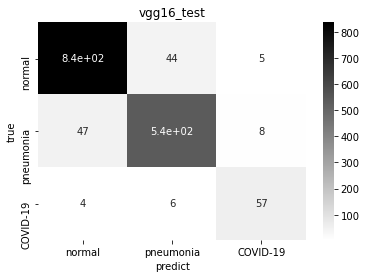

In class: normal	Total samples: 885	True predict samples: 836
precision = 0.9425,	recall = 0.9446,	f1-score = 0.9436

In class: pneumonia	Total samples: 594	True predict samples: 539
precision = 0.9151,	recall = 0.9074,	f1-score = 0.9112

In class: COVID-19	Total samples: 67	True predict samples: 57
precision = 0.8143,	recall = 0.8507,	f1-score = 0.8321

AVERAGE F1-SCORE = 0.9263 
 ------------------------------------------------------------------------------------------


In [9]:
y = tf.keras.utils.to_categorical(ytrain, 3)
yv = tf.keras.utils.to_categorical(ytest, 3)
model_checkpoint_callback = ModelCheckpoint(filepath='Models/vgg16.h5', monitor='val_accuracy',
                                            mode='max', save_best_only=True)
model = Sequential()
vgg16 = VGG16(include_top = False, input_shape = (229, 229, 3), pooling = 'avg', weights=None)
model.add(vgg16)
model.add(Flatten())
model.add(Dense(3, activation = 'softmax'))

opt = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
hist = model.fit(xtrain_229, y, batch_size=32,  epochs=21, verbose=1, validation_data=(xtest_229, yv), callbacks=[model_checkpoint_callback])
plot_history(hist, 'vgg16')
print('\n', '-'*90, '\n')
print('VGG16 VALIDATION')
test(xtrain_229, ytrain, 'Models/vgg16.h5', 'vgg16_train')
test(xtest_229, ytest, 'Models/vgg16.h5', 'vgg16_test')